# Libraries

In [17]:
import os
import warnings
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from urllib.parse import urlparse
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn
from wordcloud import WordCloud, STOPWORDS
import string

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

mlflow.autolog()



sys.path.append(str(Path.cwd().parent))
""" from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            ) """

2023/08/20 14:04:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


' from settings.params import (DATA_DIR_INPUT,\n                             DATA_DIR_OUTPUT,\n                             MODEL_PARAMS,\n                             REPORT_DIR,\n                             TIMEZONE,\n                            ) '

# Dataset

In [2]:
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data\sample_submission.csv
../data\test.csv
../data\train.csv


In [3]:
data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
data.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [7]:
data.shape

(7613, 5)

In [8]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# Data Preprocessing

In [10]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [11]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
missing_cols = ['keyword', 'location']
for df in [data, test_data]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [19]:
# word_count
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
data['unique_word_count'] = data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
data['stop_word_count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
data['url_count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
data['mean_word_length'] = data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

# punctuation_count
#data['punctuation_count'] = data['text'].apply(lambda x: len([c for c in str(x) if c in x.punctuation]))
#test_data['punctuation_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
data['hashtag_count'] = data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_data['hashtag_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
data['mention_count'] = data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_data['mention_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [23]:
data.info

<bound method DataFrame.info of          id     keyword     location  \
0         1  no_keyword  no_location   
1         4  no_keyword  no_location   
2         5  no_keyword  no_location   
3         6  no_keyword  no_location   
4         7  no_keyword  no_location   
...     ...         ...          ...   
7608  10869  no_keyword  no_location   
7609  10870  no_keyword  no_location   
7610  10871  no_keyword  no_location   
7611  10872  no_keyword  no_location   
7612  10873  no_keyword  no_location   

                                                   text  target  word_count  \
0     Our Deeds are the Reason of this #earthquake M...       1          13   
1                Forest fire near La Ronge Sask. Canada       1           7   
2     All residents asked to 'shelter in place' are ...       1          22   
3     13,000 people receive #wildfires evacuation or...       1           8   
4     Just got sent this photo from Ruby #Alaska as ...       1          16   
...          

In [20]:
data['keyword'] = data['keyword'].astype('category')
data['location'] = data['location'].astype('category')
data['text'] = data['text'].astype('category')

In [24]:
data.describe

<bound method NDFrame.describe of          id     keyword     location  \
0         1  no_keyword  no_location   
1         4  no_keyword  no_location   
2         5  no_keyword  no_location   
3         6  no_keyword  no_location   
4         7  no_keyword  no_location   
...     ...         ...          ...   
7608  10869  no_keyword  no_location   
7609  10870  no_keyword  no_location   
7610  10871  no_keyword  no_location   
7611  10872  no_keyword  no_location   
7612  10873  no_keyword  no_location   

                                                   text  target  word_count  \
0     Our Deeds are the Reason of this #earthquake M...       1          13   
1                Forest fire near La Ronge Sask. Canada       1           7   
2     All residents asked to 'shelter in place' are ...       1          22   
3     13,000 people receive #wildfires evacuation or...       1           8   
4     Just got sent this photo from Ruby #Alaska as ...       1          16   
...        

# Data Visualization

In [ ]:
sns.set_style("whitegrid")

In [ ]:
sns.pairplot(
    data[["keyword", "location", "text"]],
    hue="text",
    height=3,
    palette="Set1"
)

ValueError: No variables found for grid columns.

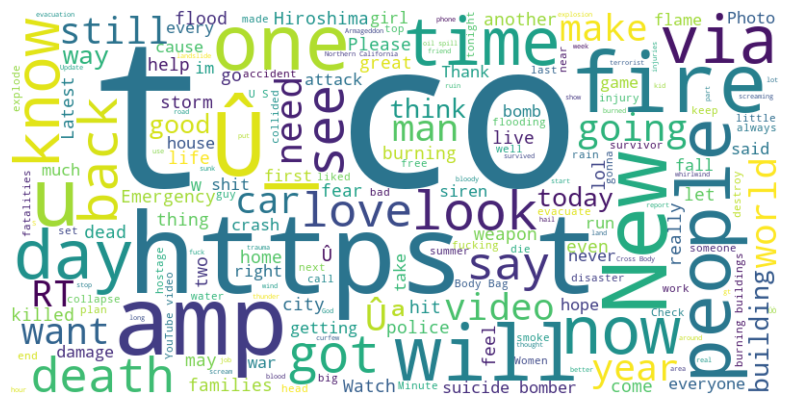

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_text = " ".join(text for text in data["text"])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Target Variable Distribution

The target values denote whether a tweet is about a real disaster (1) or not (0)

In [28]:
x=data.target.value_counts()
x

target
0    4342
1    3271
Name: count, dtype: int64

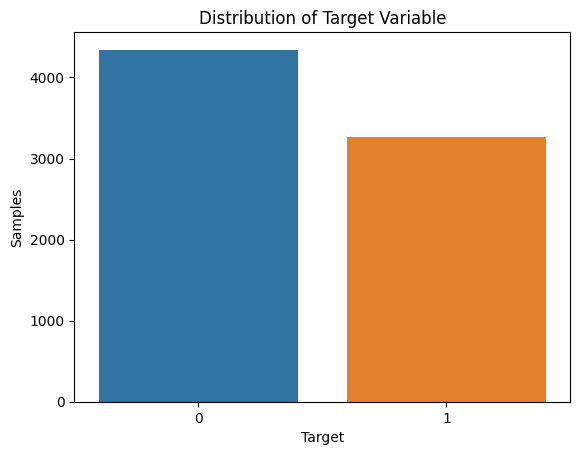

In [29]:
x = data["target"].value_counts()

# Create a bar plot
sns.barplot(x=x.index, y=x)
plt.ylabel('Samples')
plt.xlabel('Target')
plt.title('Distribution of Target Variable')
plt.show()



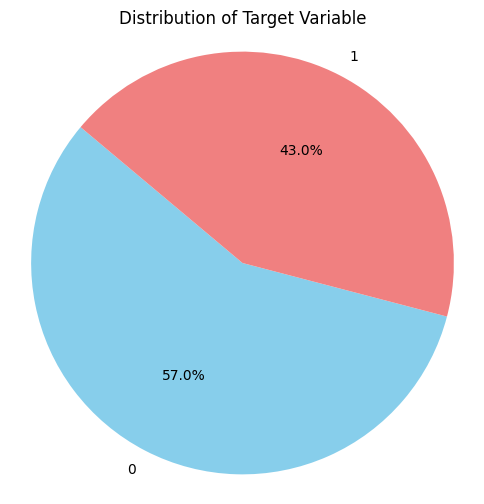

In [30]:
plt.figure(figsize=(6, 6))
plt.pie(x, labels=x.index, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightcoral"])
plt.title('Distribution of Target Variable')
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### The distribution of the target variable based on different keywords in the DataFrame

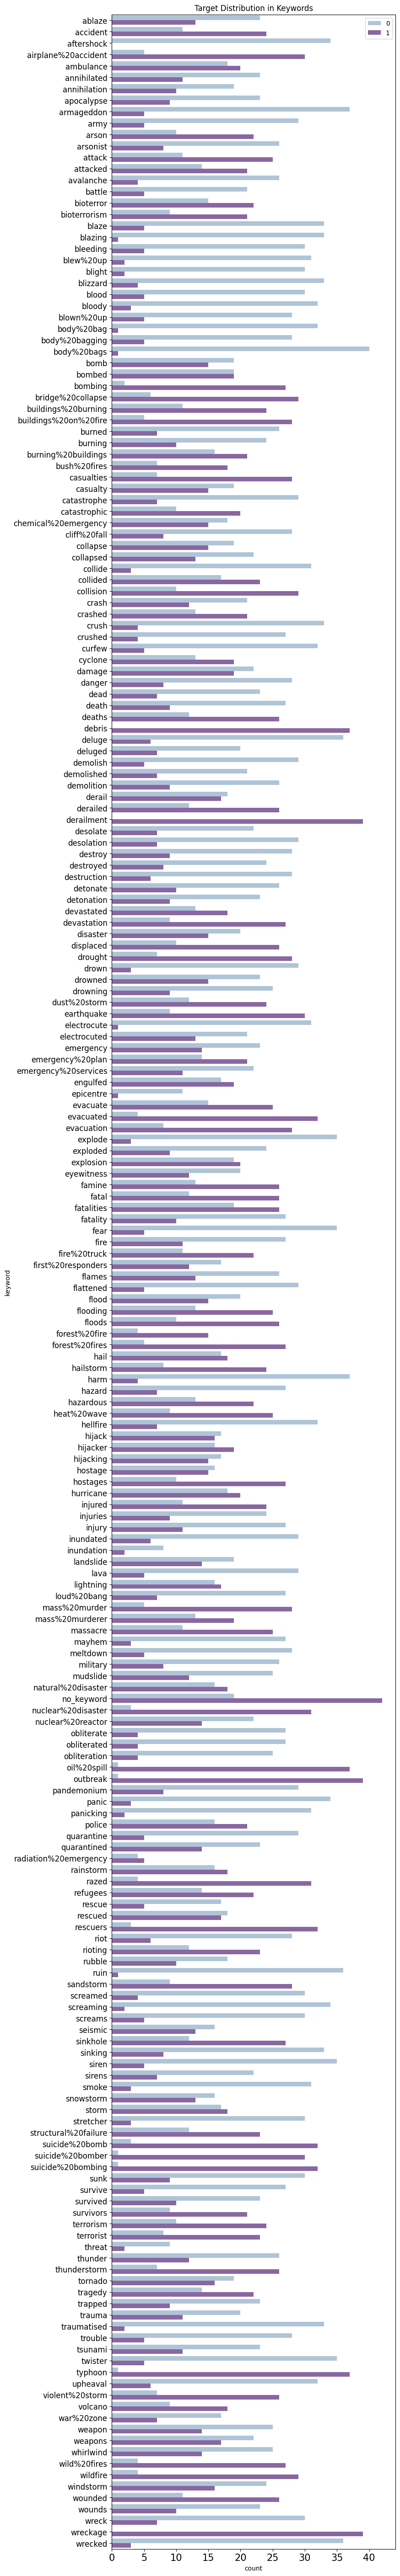

In [31]:

# Calculate the mean target value for each keyword
data['target_mean'] = data.groupby('keyword')['target'].transform('mean')

# Sort the DataFrame by target_mean in descending order
data_sorted = data.sort_values(by='target_mean', ascending=False)

# Create the figure and plot
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(
    y=data_sorted['keyword'],
    hue=data_sorted['target'],
    palette="BuPu"
)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()

# Drop the temporary 'target_mean' column
data.drop(columns=['target_mean'], inplace=True)


### The top 15 keywords based on their frequencies in the DataFrame

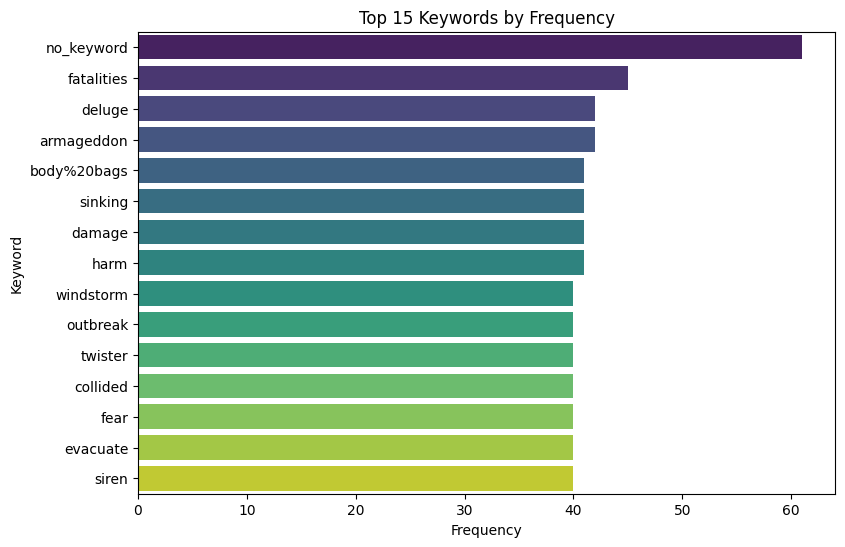

In [33]:
plt.figure(figsize=(9, 6))
sns.countplot(
    y=data['keyword'],
    order=data['keyword'].value_counts().iloc[:15].index,
    palette="viridis"  # You can customize the color palette if desired
)
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 15 Keywords by Frequency')
plt.show()


# Modèles à tester: